# Udacity Self-Driving Car Nanodegree

## Advanced Lane Finding Project

The goals / steps of this project are the following:
 
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Imports

In [1]:
import numpy as np
import cv2
import pickle
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

%matplotlib inline


## Compute the camera calibration using chessborad images

In [2]:
chess_image_folder = 'output_images/undisorted_chessboard_images'
if not os.path.exists(chess_image_folder):
    os.makedirs(chess_image_folder)

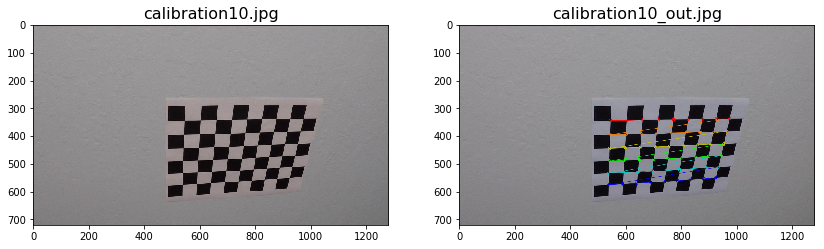

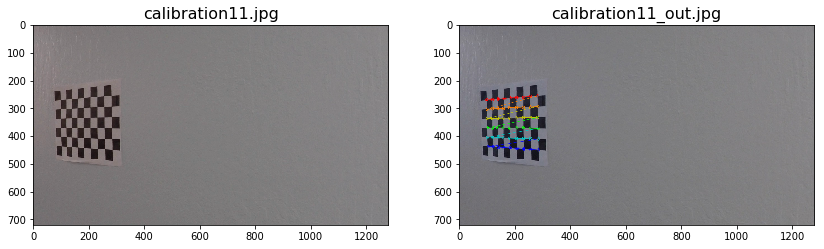

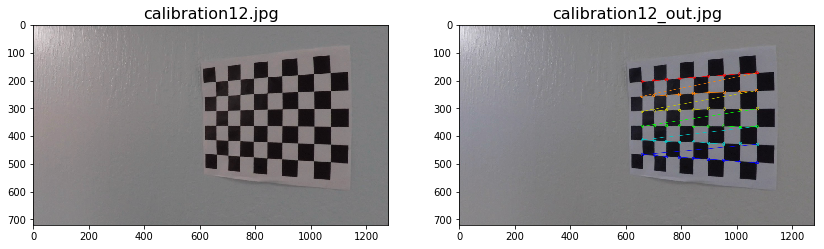

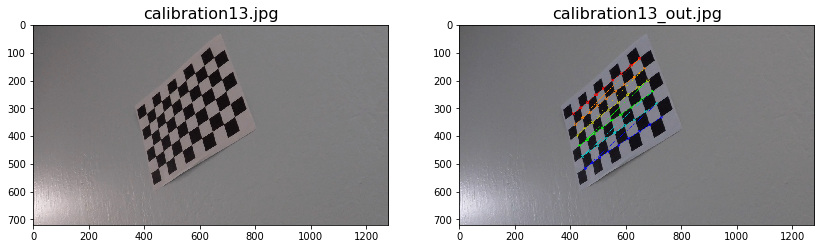

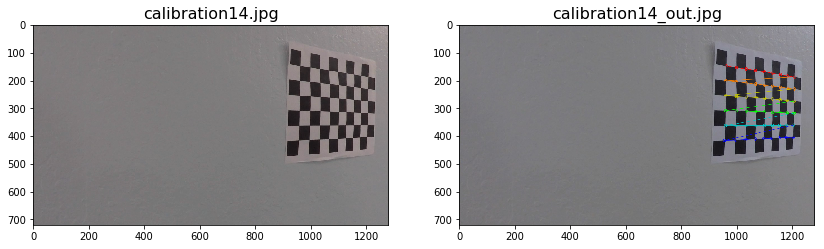

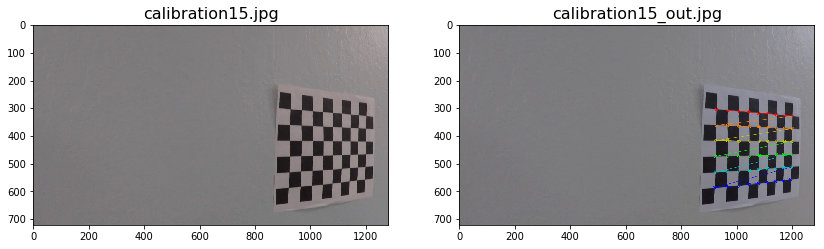

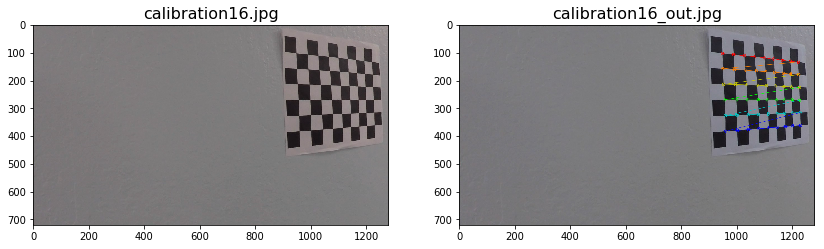

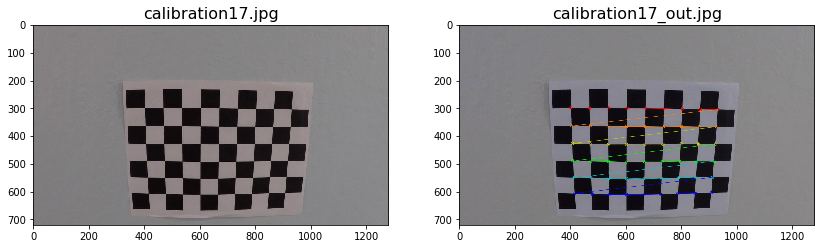

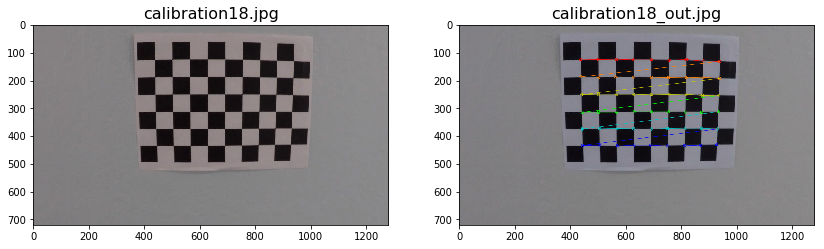

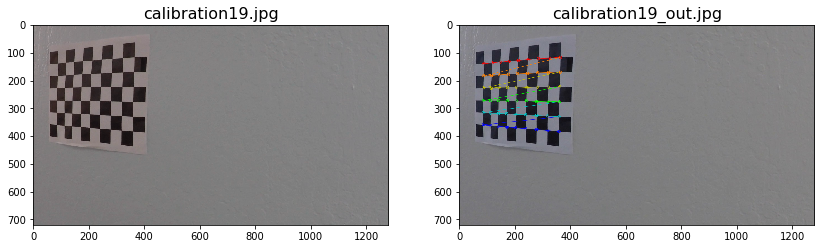

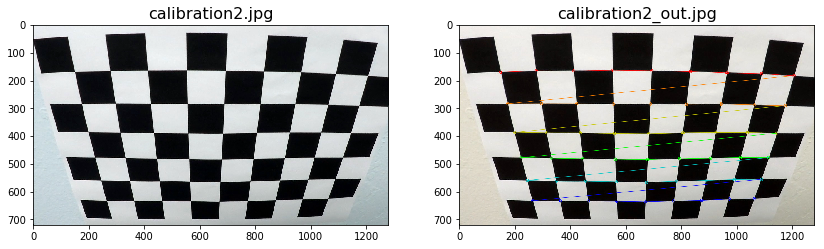

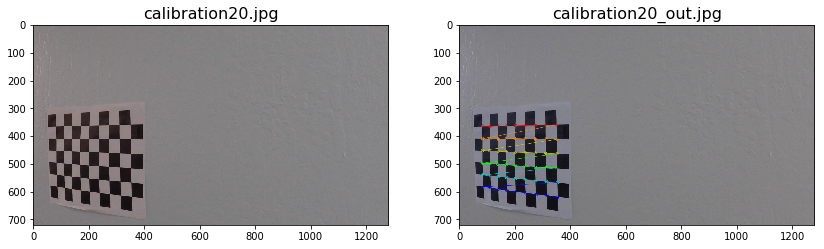

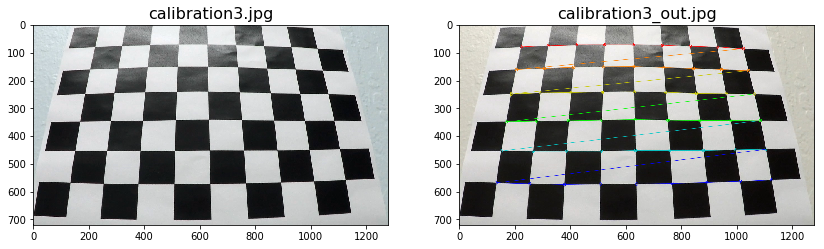

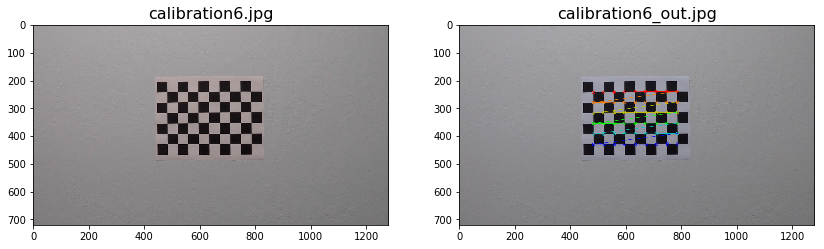

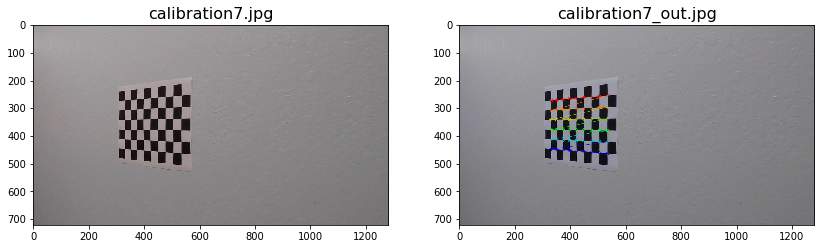

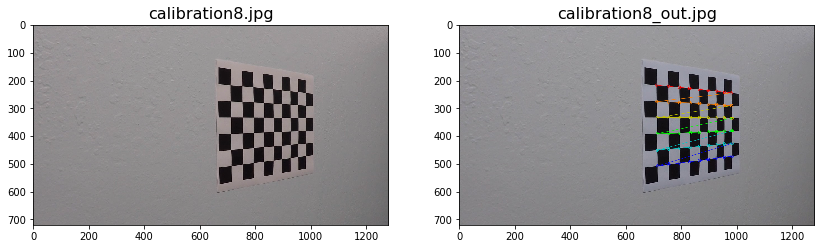

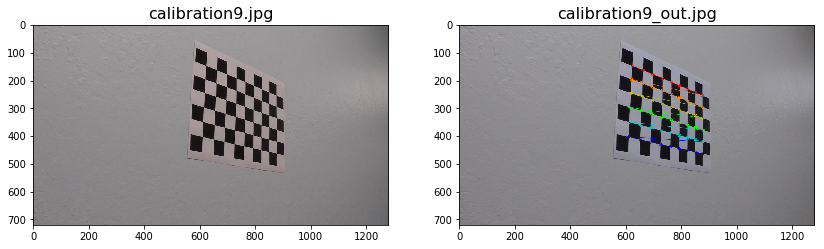

In [3]:
#prepare object points
nx = 9
ny = 6
channels = 3

imgpoints = []
objpoints = []
objp = np.zeros((ny * nx, channels), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Make a list of calibration images
fname = './camera_cal/calibration*.jpg'
calib_images = glob.glob(fname)

count_column = 1
i = 0
for calib_image in calib_images:

    name = './camera_cal/' + calib_image.split('/')[-1]
    img = cv2.imread(name)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        fig, (axL, axR) = plt.subplots(ncols=2, figsize=(14,5))

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        axL.imshow(cv2.imread(name))
        axL.set_title(calib_image.split('/')[-1], fontsize=16)
        axR.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axR.set_title(calib_image.split('/')[-1].split('.')[0]+'_out.jpg', fontsize=16)
        plt.savefig(chess_image_folder+"/"+calib_image.split('/')[-1].split('.')[0]+'_out.jpg')

## Original camera image and undistorted image

In [4]:
test_image_name = './test_images/*.jpg'
test_images = glob.glob(test_image_name)

In [5]:
def undistortion(img):
    # Convert to grayscale
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

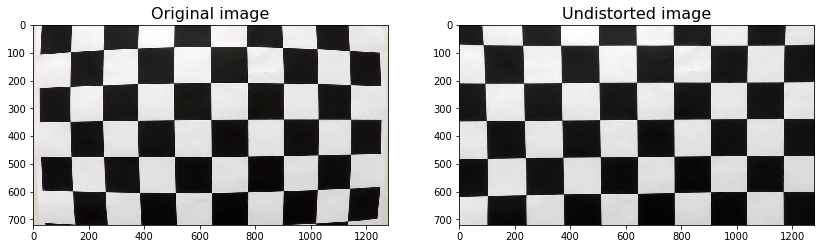

In [6]:
test_image = plt.imread(calib_images[0])
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undistorted_image = undistortion(gray)
# Draw and display the corners
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(14,5))
axL.imshow(test_image, cmap='gray')
axL.set_title('Original image', fontsize=16)
axR.imshow(undistorted_image, cmap='gray')
axR.set_title('Undistorted image', fontsize=16)
plt.savefig('./output_images/undisorted_chessboard_images/undistorted_chess_board.jpg')


## Perspective transform

A perspective transform maps the points in a given image to different, desired, image points with a new perspective.This  will be useful for calculating the lane curvature.

In [7]:
# Define perspective transform function
def perspective_transform(img):

    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float32(
        [[740, 460],
         [1230, 670],
         [70, 670],
         [545, 460]])

    dst = np.float32(
        [[1280, 0],
         [1280, 720],
         [0, 720],
         [0, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_im = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped_im, Minv


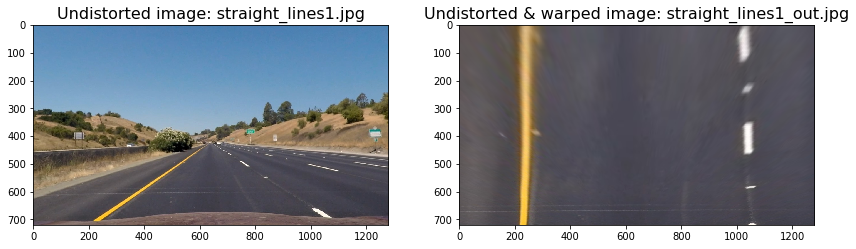

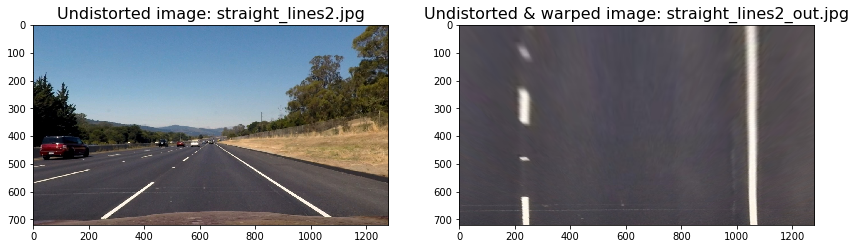

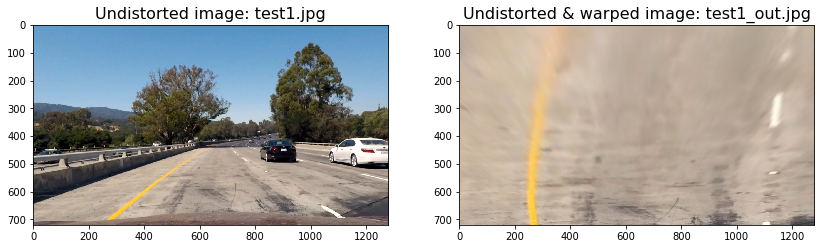

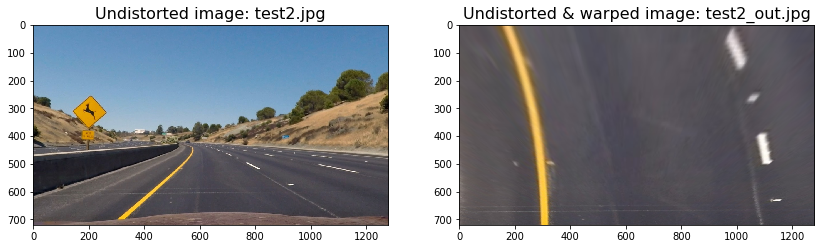

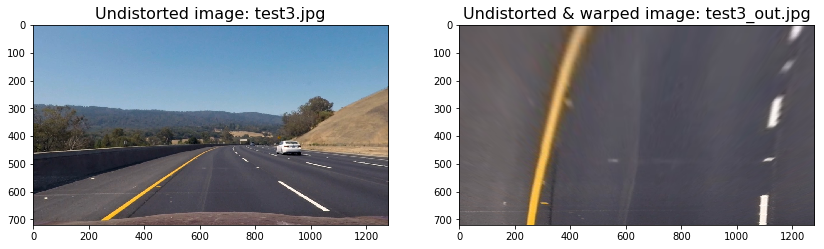

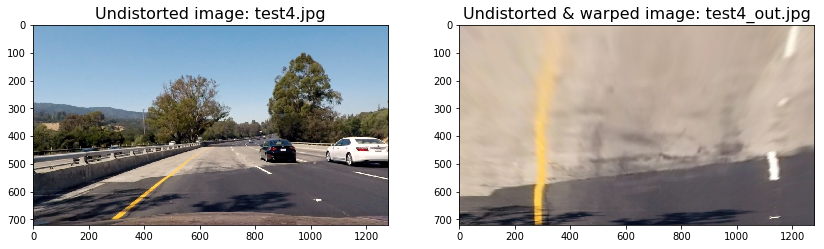

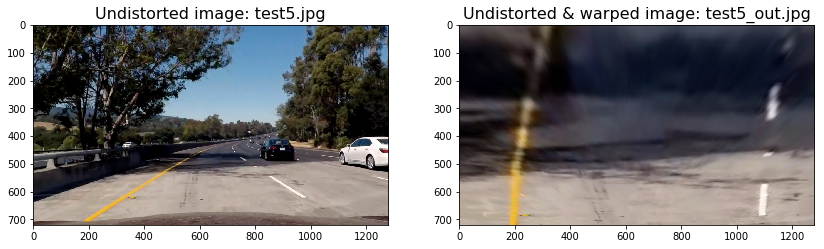

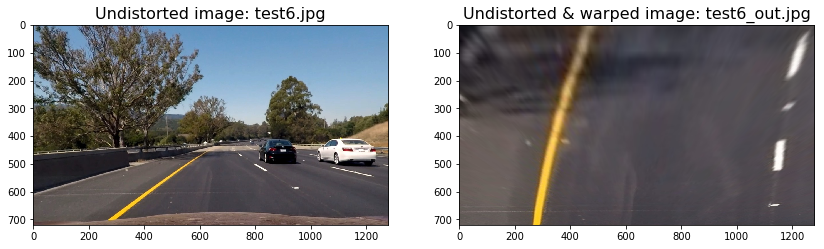

In [8]:
for test_image in test_images:
    name = './test_images/' + test_image.split('/')[-1]
    test_image = plt.imread(name)
    undistorted_image = undistortion(test_image)
    warped_image, Minv = perspective_transform(undistorted_image)
    
    # Draw and display the corners
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(14, 5))
    axL.imshow(undistorted_image, cmap = 'gray')
    axL.set_title('Undistorted image: ' + name.split('/')[-1], fontsize=16)
    axR.imshow(warped_image, cmap = 'gray')
    axR.set_title('Undistorted & warped image: ' + name.split('/')[-1].split('.')[0] + '_out.jpg',
                  fontsize=16)
#     plt.savefig('./output_images/birds_eye_view_images'+'/'+ name.split('/')[-1].split('.')[0]+'wraped_out.jpg')

## Detect lane pixels and fit to find the lane boundary

In [9]:
def pipeline(img, l_thresh=(225, 255), b_thresh=(155, 200)):
    img = np.copy(img)
    # Convert to LUV color space and separate the l channel
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    # Convert to LAB color space and separate the l channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    
    # Threshold x gradient
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    return combined_binary

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        # x values in windows
        self.windows = np.ones((3, 12)) * -1

## Determine the curvature of the lane and vehicle position with respect to center

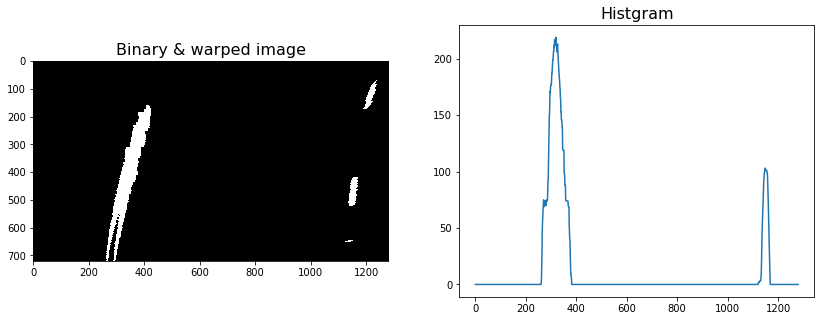

In [11]:
# camera calibration
undistort_image = undistortion(test_image)
# Apply pipeline to the image to create black and white image
combined_image = pipeline(undistort_image)
# Warp the image to make lanes parallel to each other
binary_warped, Minv = perspective_transform(combined_image)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# plt.plot(histogram)
# plt.show()

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(14,5))
axL.imshow(binary_warped, cmap = 'gray')
axL.set_title('Binary & warped image', fontsize=16)
axR.plot(histogram)
axR.set_title('Histgram', fontsize=16)
fig.show()

In [12]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualisation

<function matplotlib.pyplot.show>

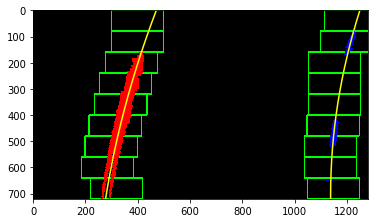

In [13]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show

### Skip the sliding windows step once you know where the lines are
Search in a margin around the previous line position like this:

In [14]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

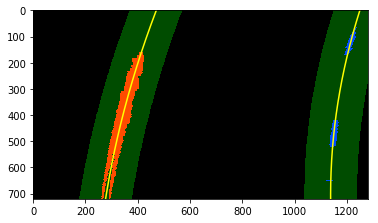

In [15]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [16]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

# Define conversions in x and y from pixels space to meters
ym_per_pix = 25/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1000 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1050.38636675 m 724.66455741 m


In [17]:
def calc_curvature(ploty, fitxy):
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 1000  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty * ym_per_pix, fitxy * xm_per_pix, 2)
    # Calculate the new radious of curvature
    curverad = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    return curverad

In [18]:
def find_peaks(image, y_window_top, y_window_bottom, x_left, x_right):
    # Find the historgram from the image inside the window
    histogram = np.sum(image[int(y_window_top):int(y_window_bottom), :], axis=0)
    # Find the max from the histogram
    if len(histogram[int(x_left):int(x_right)]) > 0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2

In [19]:
def sanity_check(lane, curverad, fitx, fit):
    # Sanity check for the lane
    if lane.detected:  # If lane is detected
        # If sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
        # If sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        # If lane was not detected and no curvature is defined
        if lane.radius_of_curvature:
            if abs(curverad / lane.radius_of_curvature - 1) < 1:
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
            else:
                lane.detected = False
                fitx = lane.allx
                # If curvature was defined
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

In [20]:
def find_lanes(n, image, x_window, lanes, left_lane_x, left_lane_y, right_lane_x, right_lane_y, window_ind):
    # 'n' windows will be used to identify peaks of histograms
    # Set index1. This is used for placeholder.
    index1 = np.zeros((n + 1, 2))
    index1[0] = [250, 1100]
    index1[1] = [250, 1100]
    # Set the first left and right values
    left, right = (250, 1100)
    # Set the center
    center = 675
    # Set the previous center
    center_pre = center
    # Set the direction
    direction = 0
    for i in range(n - 1):
        # set the window range.
        y_window_top = 720 - 720 / n * (i + 1)
        y_window_bottom = 720 - 720 / n * i
        # If left and right lanes are detected from the previous image
        if (left_lane.detected == False) and (right_lane.detected == False):
            # Find the historgram from the image inside the window
            left = find_peaks(image, y_window_top, y_window_bottom, index1[i + 1, 0] - 200, index1[i + 1, 0] + 200)
            right = find_peaks(image, y_window_top, y_window_bottom, index1[i + 1, 1] - 200, index1[i + 1, 1] + 200)
            # Set the center
            center_pre = center
            center = (left + right) / 2
            direction = center - center_pre
        # If both lanes were detected in the previous image
        # Set them equal to the previous one
        else:
            left = left_lane.windows[window_ind, i]
            right = right_lane.windows[window_ind, i]
        # Make sure the distance between left and right lanes are wide enough
        if abs(left - right) > 600:
            # Append coordinates to the left lane arrays
            left_lane_array = lanes[(lanes[:, 1] >= left - x_window) & (lanes[:, 1] < left + x_window) &
                                    (lanes[:, 0] <= y_window_bottom) & (lanes[:, 0] >= y_window_top)]
            left_lane_x += left_lane_array[:, 1].flatten().tolist()
            left_lane_y += left_lane_array[:, 0].flatten().tolist()
            if not math.isnan(np.mean(left_lane_array[:, 1])):
                left_lane.windows[window_ind, i] = np.mean(left_lane_array[:, 1])
                index1[i + 2, 0] = np.mean(left_lane_array[:, 1])
            else:
                index1[i + 2, 0] = index1[i + 1, 0] + direction
                left_lane.windows[window_ind, i] = index1[i + 2, 0]
            # Append coordinates to the right lane arrays
            right_lane_array = lanes[(lanes[:, 1] >= right - x_window) & (lanes[:, 1] < right + x_window) &
                                     (lanes[:, 0] < y_window_bottom) & (lanes[:, 0] >= y_window_top)]
            right_lane_x += right_lane_array[:, 1].flatten().tolist()
            right_lane_y += right_lane_array[:, 0].flatten().tolist()
            if not math.isnan(np.mean(right_lane_array[:, 1])):
                right_lane.windows[window_ind, i] = np.mean(right_lane_array[:, 1])
                index1[i + 2, 1] = np.mean(right_lane_array[:, 1])
            else:
                index1[i + 2, 1] = index1[i + 1, 1] + direction
                right_lane.windows[window_ind, i] = index1[i + 2, 1]
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y

In [21]:

# Function to find the fitting lines from the warped image
def fit_lanes(image):
    # define y coordinate values for plotting
    #     yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    # find the coordinates from the image
    lanes = np.argwhere(image)
    # Coordinates for left lane
    left_lane_x = []
    left_lane_y = []
    # Coordinates for right lane
    right_lane_x = []
    right_lane_y = []

    # Find lanes from three repeated procedures with different window values
    # Find lanes from three repeated procedures with different window values
    left_lane_x, left_lane_y, right_lane_x, right_lane_y = find_lanes(4, image, 25, lanes,
                                                                      left_lane_x, left_lane_y,
                                                                      right_lane_x, right_lane_y, 0)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y = find_lanes(6, image, 50, lanes,
                                                                      left_lane_x, left_lane_y,
                                                                      right_lane_x, right_lane_y, 1)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y = find_lanes(8, image, 75, lanes,
                                                                      left_lane_x, left_lane_y,
                                                                      right_lane_x, right_lane_y, 2)
    # Find the coefficients of polynomials
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    # Find curvatures
    left_curvature = calc_curvature(ploty, left_fitx)
    right_curvature = calc_curvature(ploty, right_fitx)
    
    # Sanity check for the lanes
    left_fitx  = sanity_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = sanity_check(right_lane, right_curverad, right_fitx, right_fit)

    return ploty, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, left_curvature

In [22]:
# draw poly on an image
# def draw_poly(image, warped, yvals, left_fitx, right_fitx, Minv):
def draw_poly(image, warped, yvals, left_fitx, right_fitx,
              left_lane_x, left_lane_y, right_lane_x, right_lane_y, Minv, curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Lane curvature radius: {} m".format(int(curvature))
    cv2.putText(result, text, (200, 100), font, 1.5, (255, 255, 255), 2)
    # Find the position of the car
    position = (640 - ((right_fitx[-1]+left_fitx[-1])/2))*3.7/1000

    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result, text, (200, 150), font, 1.5, (255, 255, 255), 2)
    return result

## Warp the detected lane boundaries back onto the original image

In [23]:
def process_image(image):
    #     test_image = plt.imread(test_images[0])
    # camera calibration
    undistort_image = undistortion(image)
    # Apply pipeline to the image to create black and white image
    combined_image = pipeline(undistort_image)
    # Warp the image to make lanes parallel to each other
    binary_warped, Minv = perspective_transform(combined_image)
    # Find the lines fitting to left and right lanes
    a, b, c, lx, ly, rx, ry, curvature = fit_lanes(binary_warped)
    # Return the original image with colored region
    result = draw_poly(image, binary_warped, a, b, c, lx, ly, rx, ry, Minv, curvature)
    return result



## Output visual display

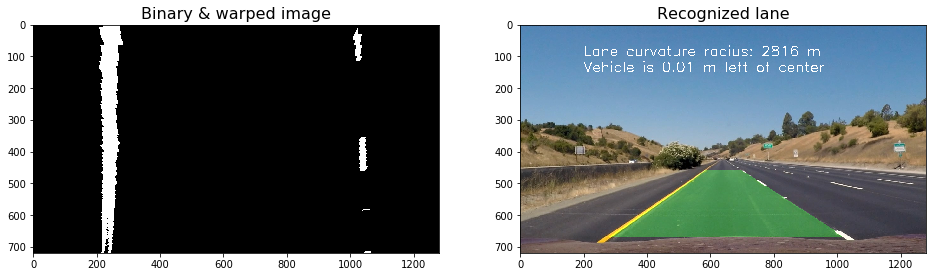

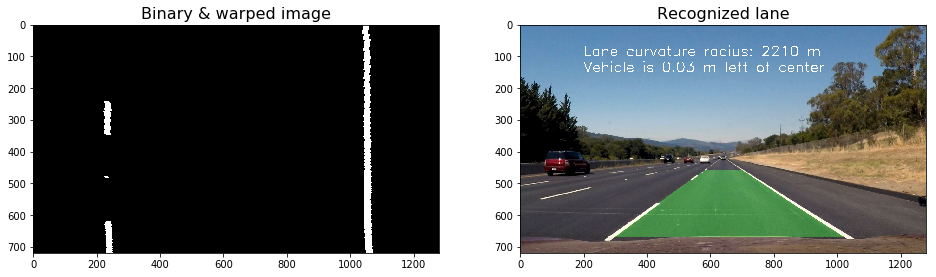

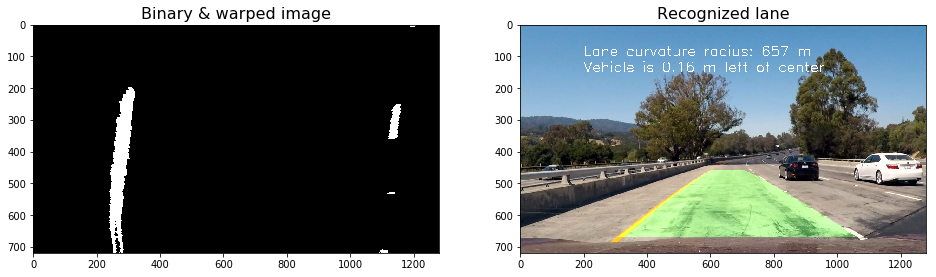

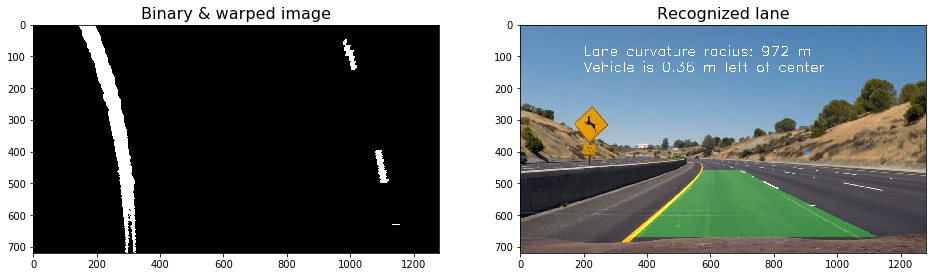

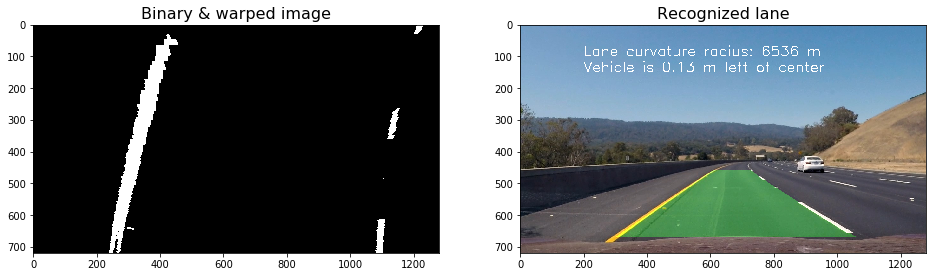

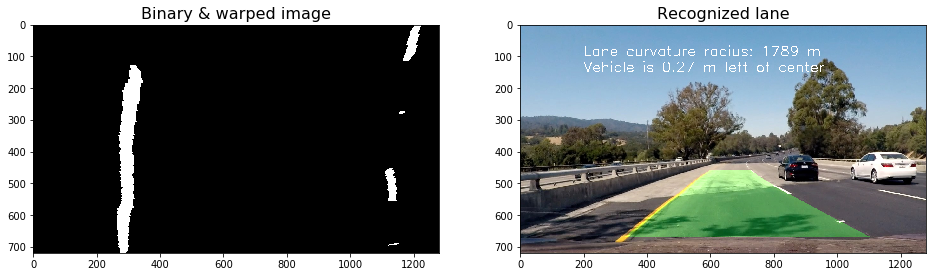

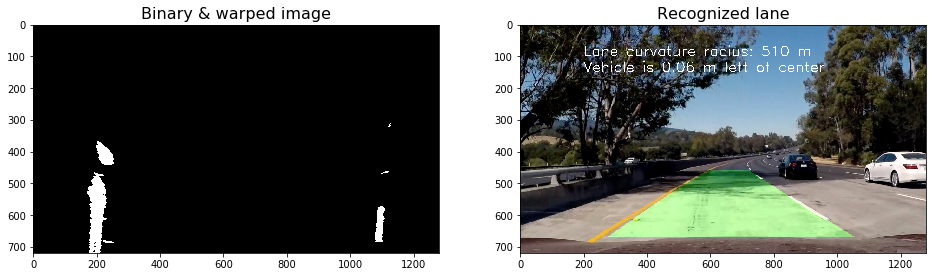

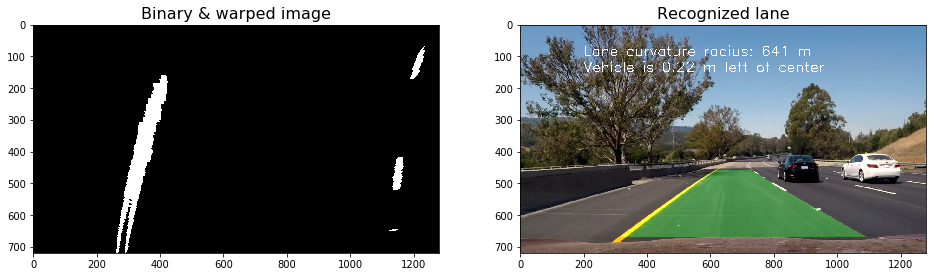

In [24]:
test_images = 'test_images/*.jpg'
test_images_list = glob.glob(test_images)
left_lane = Line()
right_lane = Line()

for image_name in test_images_list:
    image = plt.imread(image_name)
    undistort_image = undistortion(image)
    combined_image = pipeline(undistort_image)
    binary_warped, Minv = perspective_transform(combined_image)

    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(16,6))
    axL.imshow(binary_warped, cmap = 'gray')
    axL.set_title('Binary & warped image', fontsize=16)
    axR.imshow(process_image(image))
    axR.set_title('Recognized lane', fontsize=16)
    plt.savefig('./output_images/final_output_image/'+image_name.split('/')[-1].split('.')[0]+'_out.jpg')

## Create video 

In [25]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
output = 'P4_result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video P4_result_video.mp4
[MoviePy] Writing video P4_result_video.mp4


100%|█████████▉| 1260/1261 [02:03<00:00, 10.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_result_video.mp4 

CPU times: user 2min 40s, sys: 9.32 s, total: 2min 49s
Wall time: 2min 3s
